In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
## load Cleaned Data
cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")
cleaned_data.index = cleaned_data.index.astype(int)

#load Adoption Data
tract_adoption_data = pd.read_csv("tract_adoption_data.csv")
print(tract_adoption_data.head)

/var/folders/67/r87g720s2653g554zdhtz1vh0000gn/T/ipykernel_20956/571322288.py:2: DtypeWarning: Columns (181) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")


<bound method NDFrame.head of         Unnamed: 0        GEOID state_abbr            county_name  year   
0            18734  53067010600         WA        Thurston County  2021  \
1            62643  53067010600         WA        Thurston County  2022   
2            62644  53067010600         WA        Thurston County  2023   
3            62645  53067010600         WA        Thurston County  2024   
4            62646  53067010600         WA        Thurston County  2025   
...            ...          ...        ...                    ...   ...   
213804       77084   6071003404         CA  San Bernardino County  2021   
213805       77085   6071003404         CA  San Bernardino County  2022   
213806       77086   6071003404         CA  San Bernardino County  2023   
213807       77087   6071003404         CA  San Bernardino County  2024   
213808       77088   6071003404         CA  San Bernardino County  2025   

       scenario        kw   yearly_kwh  
0           bau  3.538292  3

In [23]:
#Calculate avoided emissions and air pollution

#From EPA 2022 AVERT Emission Rates (lb/KWh) for Distributed PV
nat_avg_emission_rates = {
    'co2': 1.451,
    'pm25': 0.00009  
}
nat_distpv_cap_factor = 0.2526
hours_per_year = 8760

#calculate for total 2023 Cap 1.8GW
total_avoided_gen = 1.8 * 1000000 * hours_per_year * nat_distpv_cap_factor
total_co2_avoided = total_avoided_gen * nat_avg_emission_rates['co2'] 
total_pm25_avoided = total_avoided_gen * nat_avg_emission_rates['pm25']
print(total_co2_avoided)
print(total_pm25_avoided)

#Calculate per tract
benefits_data=tract_adoption_data.copy()
benefits_data['pm25_avoided'] = benefits_data['yearly_kwh']*nat_avg_emission_rates['pm25']
benefits_data['co2_avoided'] = benefits_data['yearly_kwh']*nat_avg_emission_rates['co2']

#Next: Compare with impact scores - where would the higest impact be? how much?


5779328356.8
358469.712


In [25]:
print(benefits_data.groupby(['year', 'scenario'])['kw'].sum())

year  scenario
2010  bau           312.010054
2011  bau          1601.286202
2012  bau          3649.959842
2013  bau          9166.944611
2014  bau         15345.867552
2015  bau         28053.114534
2016  bau         44687.271128
2017  bau         53555.202664
2018  bau         55990.685618
2019  bau         63398.150535
2020  bau         69710.148801
2021  bau         81240.662531
      high        84490.289032
      med         82865.475782
2022  bau         70535.910625
      high        73357.347050
      med         71946.628838
2023  bau         72892.387636
      high        75808.083142
      med         74350.235389
2024  bau         75248.864647
      high        78258.819233
      med         76753.841940
2025  bau         77605.341658
      high        80709.555324
      med         79157.448491
Name: kw, dtype: float64


In [29]:
#Calculate Job Creation

#Job multiplier per kw from NREL model
pv_job_mult = .0029 

#calculate for total 2023 Cap 1.8GW
total_jobs = 1.8 * 1000000 * pv_job_mult
print(total_jobs)

#Calculate per tract
benefits_data['jobs_created'] = benefits_data['kw']*pv_job_mult

print(benefits_data.head)

#Next: Compare with num_installers and med_solar_install

5220.0
<bound method NDFrame.head of         Unnamed: 0        GEOID state_abbr            county_name  year   
0            18734  53067010600         WA        Thurston County  2021  \
1            62643  53067010600         WA        Thurston County  2022   
2            62644  53067010600         WA        Thurston County  2023   
3            62645  53067010600         WA        Thurston County  2024   
4            62646  53067010600         WA        Thurston County  2025   
...            ...          ...        ...                    ...   ...   
213804       77084   6071003404         CA  San Bernardino County  2021   
213805       77085   6071003404         CA  San Bernardino County  2022   
213806       77086   6071003404         CA  San Bernardino County  2023   
213807       77087   6071003404         CA  San Bernardino County  2024   
213808       77088   6071003404         CA  San Bernardino County  2025   

       scenario        kw   yearly_kwh  pm25_avoided   co2_avo

In [56]:
#Code scrap for energy burden calculation

#Avg cost of panels from NREL report
install_cost_dlkw = 3000
lic_itc = 0.4

# new energy burden - old energy burden / old energy burden = % change
energy_burden_data = cleaned_data[['yearly_sunlight_kwh_median', 'kw_median', 'avg_monthly_consumption_kwh', 'dlrs_kwh', 'median_income', 'energy_burden']].copy()
# print(energy_burden_data.head)

#yearly cost = ((monthly consupmtion x 12) - new capacity) x cost
# energy_burden_data['yearly_energy_cost_high'] = ((energy_burden_data['avg_monthly_consumption_kwh']*12) - energy_burden_data['yearly_sunlight_kwh_median']) * energy_burden_data['dlrs_kwh']
energy_burden_data['yearly_energy_cost'] = ((energy_burden_data['avg_monthly_consumption_kwh']*12) - energy_burden_data['yearly_sunlight_kwh_median']) * energy_burden_data['dlrs_kwh']
energy_burden_data['median_pvinstall_cost_itc'] = energy_burden_data['kw_median']*install_cost_dlkw *(1-0.4)

energy_burden_data['energy_burden_high'] = (energy_burden_data['yearly_energy_cost']/energy_burden_data['median_income']) * 100
energy_burden_data['energy_burden_med'] = ((energy_burden_data['yearly_energy_cost'] + energy_burden_data['median_pvinstall_cost_itc'])/energy_burden_data['median_income']) * 100
energy_burden_data['energy_burden_chg'] = (energy_burden_data['energy_burden_high'] - energy_burden_data['energy_burden'] / energy_burden_data['energy_burden']) * 100

#Given you get an array that can handle your consumption, and you get the ITC
# how many years would it take to pay off the panels if the energy burden was kept the same?

#first calculate the #of hours per year for the area to get the capacity factor
energy_burden_data['pv_cap_factor'] = energy_burden_data['yearly_sunlight_kwh_median']/energy_burden_data['kw_median']

#calculate the equivalent capacity needed to cover yearly consumption
energy_burden_data['equal_pvinstall'] = (energy_burden_data['avg_monthly_consumption_kwh']*12)/energy_burden_data['pv_cap_factor']

#calculate the cost
energy_burden_data['equal_pvinstall_cost_itc'] = energy_burden_data['equal_pvinstall']*install_cost_dlkw *(1-0.4)

#calculate the number of years it would take to pay off the cost of the installation if the energy burden were kept the same
energy_burden_data['payoff_years'] = energy_burden_data['equal_pvinstall_cost_itc'] / ((energy_burden_data['energy_burden']/100)*energy_burden_data['median_income'])
#change in energy burden = new energy burden - old energy burden / old energy burden

print(energy_burden_data.head)

<bound method NDFrame.head of              yearly_sunlight_kwh_median  kw_median   
GEOID                                                
53067010600                 8204.921338       9.00  \
53067011500                13135.612170      14.50   
53067011300                12302.533000      13.00   
53067011200                12692.213070      13.50   
53067010920                11110.893700      12.00   
...                                 ...        ...   
6071007408                 16562.247300      10.25   
6071007409                 13348.937480       8.25   
6071007410                 18315.401560      11.25   
6071007303                 13068.990100       8.75   
6071003404                 14607.244600       9.25   

             avg_monthly_consumption_kwh  dlrs_kwh  median_income   
GEOID                                                               
53067010600                   867.008585   0.11116        26769.0  \
53067011500                   867.008585   0.11116        30

count    23372.000000
mean      -378.784258
std       1461.494488
min     -44659.510157
25%       -390.635838
50%       -152.809400
75%        -20.019406
max       2406.526248
Name: energy_burden_chg, dtype: float64


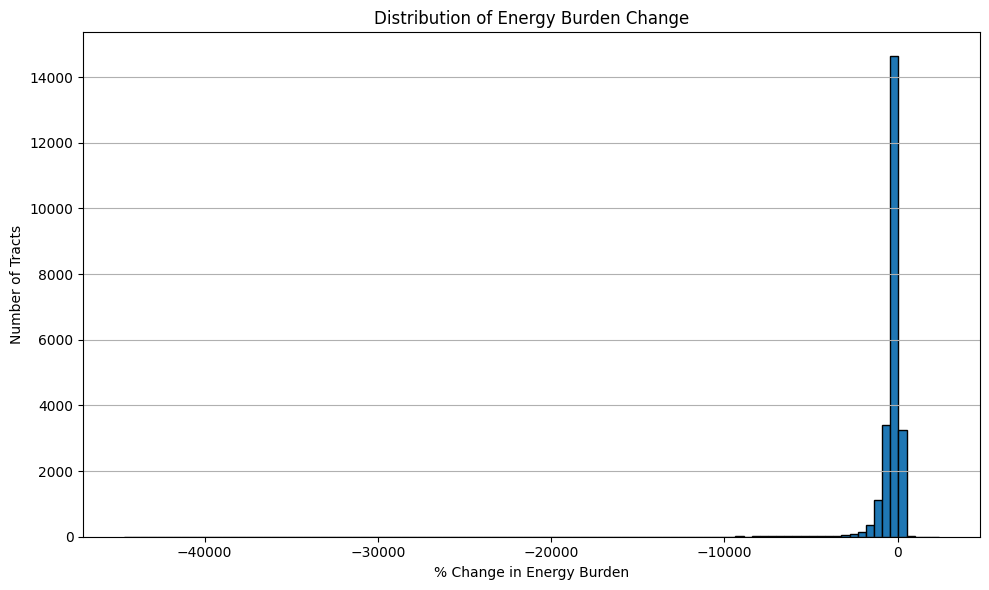

In [58]:
# Create histogram for Change in Energy Burden

#get summary statistics
print(energy_burden_data['energy_burden_chg'].describe())

plt.figure(figsize=(10, 6))
plt.hist(energy_burden_data['energy_burden_chg'], bins=100, edgecolor='black')

# Customize the plot
plt.xlabel('% Change in Energy Burden')
plt.ylabel('Number of Tracts')
plt.title('Distribution of Energy Burden Change')
plt.grid(axis='y')  # Optional: Show gridlines on the y-axis

plt.tight_layout()
plt.show()

count    23372.000000
mean        17.875958
std         12.454975
min          2.710810
25%         11.696774
50%         15.868838
75%         21.192301
max        494.890590
Name: payoff_years, dtype: float64


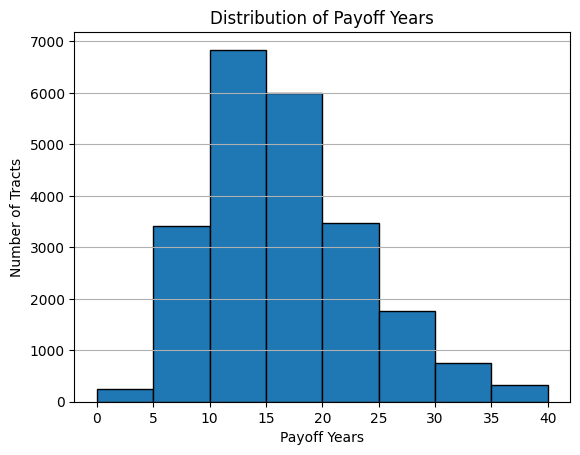

In [78]:
# Create histogram for Payoff Years

#get summary statistics
print(energy_burden_data['payoff_years'].describe())

threshold_min = 0  # Minimum acceptable value for 'payoff_years'
threshold_max = 40  # Maximum acceptable value for 'payoff_years'

# Filter the data to remove extreme values
filtered_data = energy_burden_data[(energy_burden_data['payoff_years'] >= threshold_min) & (energy_burden_data['payoff_years'] <= threshold_max)]

bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
# Create the histogram using the filtered data
plt.hist(filtered_data['payoff_years'], bins=bins, edgecolor='black')

# Customize the plot
plt.xlabel('Payoff Years')
plt.ylabel('Number of Tracts')
plt.title('Distribution of Payoff Years')
plt.grid(axis='y')  # Optional: Show gridlines on the y-axis

# plt.tight_layout()
plt.show()

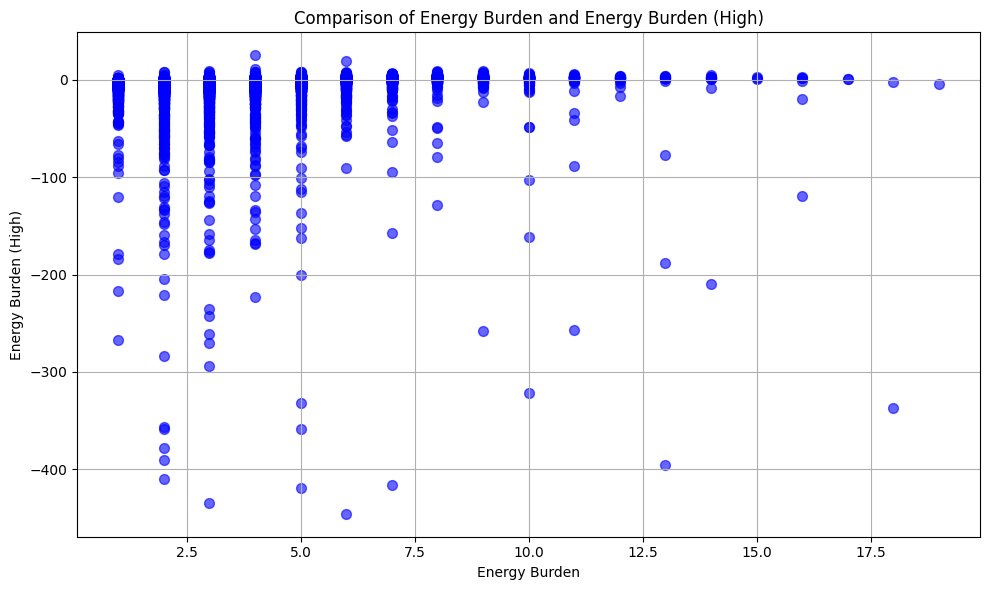

In [52]:
#Visualize energy burden change

plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size

plt.scatter(energy_burden_data['energy_burden'], energy_burden_data['energy_burden_high'], s=50, alpha=0.6, color='b')

plt.xlabel('Energy Burden')
plt.ylabel('Energy Burden (High)')
plt.title('Comparison of Energy Burden and Energy Burden (High)')
plt.grid(True)  # Optional: Show gridlines
plt.tight_layout()

plt.show()